In [14]:
import app.calibration as cal
import app.edges as e
import app.warp as w
import app.lane_finder as lf
import app.stabilizer as st

import cv2
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
from IPython.display import HTML
%matplotlib inline

(720, 1280, 3)

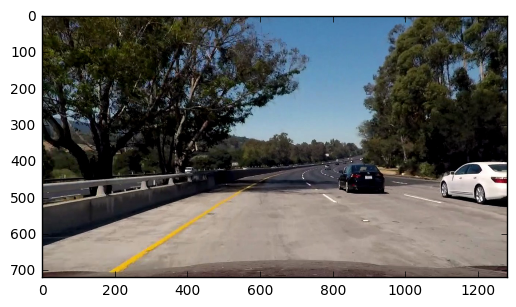

In [15]:
img = cv2.imread('extra/test2.jpg')
#img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (1280,720))
calibrator= cal.Camera_calibrator()
calibrator.initialize()
undist = calibrator.calibrate(img)

plt.imshow(undist)
undist.shape

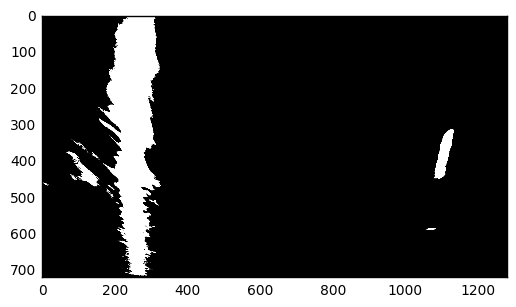

In [16]:
warped = w.warp(undist)
edges = e.Edges(warped, equalize=False) 
#gx_im = edges.gradient_x()
#gc_im = edges.gradient_color_channel()
_ = edges.gradient_color_channel(180,255,2,space=cv2.COLOR_RGB2HLS)
_ = edges.gradient_color_channel(200,255,0,space=cv2.COLOR_RGB2LUV)
_ = edges.gradient_color_channel(140,200,2,space=cv2.COLOR_RGB2LAB)

lane_detector = lf.LaneDetector(edges.combined)

plt.imshow(edges.combined, cmap='gray')

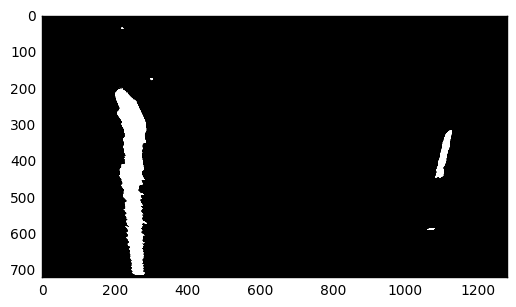

In [17]:
edges = e.Edges(warped)

#_ = edges.gradient_color_channel(180,255,2,cv2.COLOR_RGB2HLS)
#gx = edges.gradient_color_channel(220,255,0,cv2.COLOR_RGB2LUV)
##_ = edges.gradient_color_channel(190,250,2,cv2.COLOR_RGB2LAB)


_ = edges.gradient_color_channel(180,255,2,space=cv2.COLOR_RGB2HLS)
_ = edges.gradient_color_channel(220,255,0,space=cv2.COLOR_RGB2LUV)
_ = edges.gradient_color_channel(150,255,2,space=cv2.COLOR_RGB2LAB)

plt.imshow(edges.combined, cmap='gray')

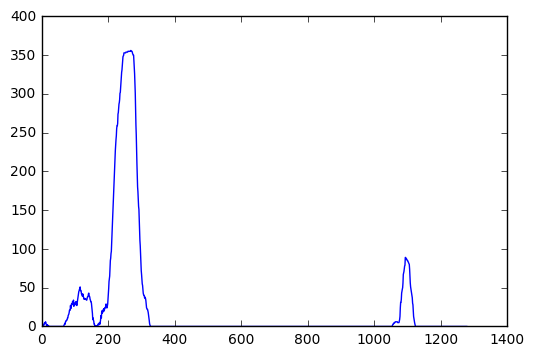

In [20]:
left_fit, right_fit, err, valid = lane_detector.find_lanes()
lanes_img = lf.plot_lanes(img, left_fit, right_fit, warped.shape, )
lanes_img = w.unwarp(lanes_img)
final = cv2.addWeighted(img,0.7,lanes_img,0.8,0)
_ = plt.plot(lane_detector.histogram)
#plt.imshow(final)

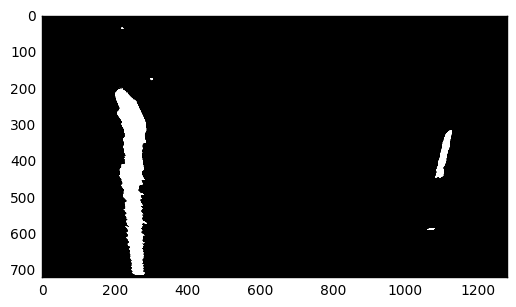

In [6]:
plt.imshow(edges.combined, cmap='gray')

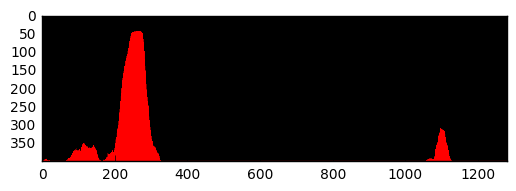

In [7]:
hist_img = lane_detector.make_hist()
plt.imshow(hist_img)

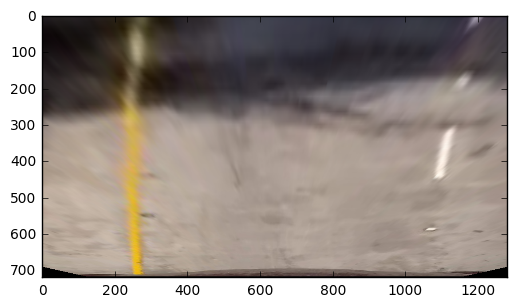

In [8]:
edg = cv2.cvtColor(edges.combined, cv2.COLOR_GRAY2RGB)
edg = edg*255
plt.imshow(warped, cmap='gray')

In [9]:
stabilizer = st.Stabilizer(window=5)
left_errors = []
right_errors = []
mask = None
frame = 0
def processor(img):
    undist = calibrator.calibrate(img)
    warped = w.warp(undist)
    global mask
    mask = None
    if mask is not None:
        if mask.sum() > 300:
            warped = cv2.bitwise_and(warped,warped, mask= mask)
        else:
            mask = None
    
    edges = e.Edges(warped, equalize=False)
    
    # 2 lines doing ok
    #_ = edges.gradient_color_channel(180,255,2,cv2.COLOR_RGB2HLS)
    #_ = edges.gradient_color_channel(225,255,0,cv2.COLOR_RGB2LUV)
    
    #_ = edges.gradient_color_channel(180,255,2,space=cv2.COLOR_RGB2HLS)
    _ = edges.gradient_color_channel(220,255,0,space=cv2.COLOR_RGB2LUV)
    _ = edges.gradient_color_channel(150,255,2,space=cv2.COLOR_RGB2LAB)
    _ = edges.gradient_color_inrange(180, 255, space=cv2.COLOR_RGB2GRAY)
    _ = edges.gradient_x(80, 180)
    
    
    lane_detector = lf.LaneDetector(edges.combined, nwindows=12, margin=100, dens=400)
    left_fit, right_fit, err, valid = lane_detector.find_lanes()
    left_err, right_err = err if err is not None else (0,0)
    if valid:
        left_fit, right_fit = stabilizer.stabilize(left_fit, right_fit, left_err, right_err, ignore_err=True)
    else:
        left_fit, right_fit = stabilizer.avg()
    
    lanes_img = lf.plot_lanes(img, left_fit, right_fit, warped.shape, fill=False)
    lanes_img = w.unwarp(lanes_img)
    final = cv2.addWeighted(img,0.7,lanes_img,0.99,0)
    l_img = final
    
    x_offset=y_offset=10
    s_img = edges.combined*255
    s_img = cv2.cvtColor(s_img, cv2.COLOR_GRAY2RGB)
    s_img_x, s_img_y = int((s_img.shape[1]/3)), int((s_img.shape[0]/3))
    s_img = cv2.resize(s_img, (s_img_y, s_img_y))
    
    l_img = final
    l_img[y_offset:y_offset+s_img.shape[0], x_offset:x_offset+s_img.shape[1]] = s_img
    
    x_offset = x_offset + 10 + s_img.shape[1]
    hist_img = lane_detector.make_hist()
    hist_img = cv2.resize(hist_img, (int(1280*0.3), s_img_y))
    l_img[y_offset:y_offset+hist_img.shape[0], x_offset:x_offset+hist_img.shape[1]] = hist_img
    
    edg_x = 525
    x_offset = int(x_offset + 10 + hist_img.shape[1])
    edg = cv2.cvtColor(edges.combined, cv2.COLOR_GRAY2RGB)
    edg = edg*255
    edg = cv2.resize(edg, (edg_x, s_img_y))
    l_img[y_offset:y_offset+edg.shape[0], x_offset:x_offset+edg.shape[1]] = edg
    
    mask = lf.plot_lanes_bw(img, left_fit, right_fit, warped.shape, 60)
    return l_img

def handle_image(img):
    global frame
    frame += 1
    original = img.copy()
    try:
        return processor(img)
    except:
        #cv2.imwrite('failed/image{}.jpg'.format(frame), original)
        pass
    return img

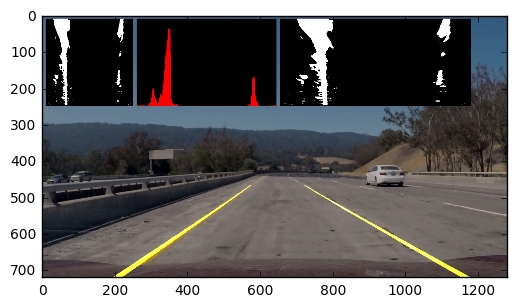

In [10]:
im = cv2.imread('extra/test1.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (1280, 720))
im = processor(im)
plt.imshow(im)

In [11]:
mask = None
white_output = 'challenge_video.mp4'
clip1 = VideoFileClip("challenge_video_out.mp4")
white_clip = clip1.fl_image(handle_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video.mp4
[MoviePy] Writing video challenge_video.mp4


100%|██████████| 485/485 [05:04<00:00,  1.62it/s]     | 1/485 [00:00<05:02,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video.mp4 

CPU times: user 7min 5s, sys: 1.27 s, total: 7min 6s
Wall time: 5min 4s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))